In [61]:
# Importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn import preprocessing
import warnings
#warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,precision_score,recall_score,f1_score,auc
from sklearn.metrics import precision_recall_curve,plot_precision_recall_curve,average_precision_score
from sklearn.model_selection import cross_val_predict

### Reading data 

In [62]:
# Reading data
data = pd.read_csv("healthcare-dataset-stroke-data.csv", encoding = 'utf-8') 

In [63]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [64]:
# Checking null values
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [65]:
# Checking datatypes
data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [66]:
# Checking distribution of numerical values
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Data Visualization and Manipulation

In [67]:
# Bar chart for missing vlaues
def plot_missing_bar(labels):
    missing_values = data.isnull().sum()
    missing_values.sort_values(inplace=True)
    missing_values = missing_values.to_frame()
    missing_values.columns = ['Count']
    missing_values.index.names = ['Name']
    missing_values['Name'] = labels
    sns.set(style="whitegrid")
    sns.barplot(x = 'Name', y = 'Count', data=missing_values)
    plt.xticks(rotation = 90)
    plt.xlabel('Variables', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.title('Missing values in variables', fontsize=16)
    plt.show()
    
# Pie chart
def plot_pie(variable, title, labels):
    df_temp = pd.DataFrame(data.groupby([variable]).count()['id'])
    colors = sns.color_palette('pastel')[0:data[variable].nunique()]
    if labels:
        plt.pie(df_temp['id'], colors = colors, labels = labels, autopct='%.0f%%')
    else:    
        plt.pie(df_temp['id'], colors = colors, labels = df_temp.index, autopct='%.0f%%')
    plt.title(title)
    plt.figure()

# Box-whisker plot
def plot_boxplot(variable, label):
    ax = sns.boxplot(x=data[variable])
    ax.set_xlabel(label)
    title = "Distribution of " + label
    ax.set_title(title)
    plt.figure()

# Histogram
def plot_histogram(variable, label):
    ax = sns.histplot(data=data, x=variable)
    ax.set_xlabel(label)
    title = "Distribution of " + label
    ax.set_title(title)
    plt.figure()

# Bar chart
def plot_chart(variable, label, rotate_label, x_labels):
    df_temp = pd.DataFrame(data.groupby([variable]).count()['id'])
    if variable == 'stroke':
        ax = sns.barplot(x=df_temp.index, y=df_temp.id, data=df_temp, order=df_temp.sort_values('id', ascending=False).index, palette=['#5975A4', '#B55D60'])
    else:
        ax = sns.barplot(x=df_temp.index, y=df_temp.id, data=df_temp, order=df_temp.sort_values('id', ascending=False).index)
    ax.set_ylabel('Number of people')
    ax.set_xlabel(label)
    ax.set_xticklabels(x_labels)
    title = "Distribution of " + label
    ax.set_title(title)
    if rotate_label:
         plt.xticks(rotation=90)
    plt.figure()

# Percentage bar chart    
def plot_relation_chart(variable, label, x_labels):
    temp = pd.DataFrame(data.groupby([variable, 'stroke'])['id'].count().unstack('stroke'))
    if variable == 'work_type':
        temp.iloc[1, 1] = 0
    temp_df = temp.apply(lambda x: x*100/sum(x), axis=1)
    temp_df.sort_values(by=[1],inplace=True,ascending=False)
    ax = temp_df.plot(kind = "bar", color = ['#5975A4', '#B55D60'], stacked=True, sort_columns=True)
    ax.set_xlabel(label)
    if x_labels:
        ax.set_xticklabels(x_labels)
    ax.set_ylabel("Percentage")
    title = "Relation between " + label + " and Stroke"
    ax.set_title(title)
    ax.legend(['No', 'Yes'], title='Stroke')
    plt.figure()
    plt.show()

# Scatter plot
def plot_scatter(variable1, variable2, x_label, y_label):
    ax = sns.scatterplot(x=variable1, y = variable2, hue="stroke", data=data, palette=['#5F9F6E', '#B55D60'])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    title = "Relation of " + x_label + " and " + y_label + " with " + "Stroke" 
    ax.set_title(title)
    ax.legend(['Yes', 'No'], title='Stroke')
    plt.figure()

# Correlation Matrix
def plot_correlationmatrix():
    ax = sns.heatmap(data.corr(), cmap="Blues", annot=True)
    ax.set_xticklabels(['ID', 'Age', 'Hypertension', 'Heart Disease', 'Avg. Glucose Level', 'BMI', 'Stroke'])
    ax.set_yticklabels(['ID', 'Age', 'Hypertension', 'Heart Disease', 'Avg. Glucose Level', 'BMI', 'Stroke'])
    plt.suptitle('Correlation between different variables', x=0.43)
    plt.show()

#  Confusion Matrix  
def plot_confusionmatrix(y_true, y_pred, cm, model_name):
    fig, ax = plt.subplots(figsize=(10, 8)) 
    ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap="Blues",
      ax=ax,
      annot_kws={"size":22}
    )
    plt.ylabel('Actual', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.suptitle(model_name, fontsize=20, y=0.9, x=0.45)  
    ax.set_xticklabels(['No Stroke', 'Stroke'], Fontsize=14)
    ax.set_yticklabels(['No Stroke', 'Stroke'], Fontsize=14)
    b, t = plt.ylim()
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t)
    plt.show()

# Bar chart for results    
def plot_result(variable, data_result):
    sns.barplot(x="Model", y= variable, data=data_result)
    title = variable + " Scores of Different Models"
    plt.title(title)
    plt.xticks(rotation = 90)
    plt.show()
    
# Side-by-side Bar chart for Feature Importance    
def plot_importance(df):
    df['idx'] = df.groupby('Model').cumcount()
    df['Sample Feature'], sample_labels = pd.factorize(df['Feature'])
    ax = sns.barplot(x='Model', y='Importance', hue='idx', data=df)
    colors = plt.cm.get_cmap('Set2').colors
    handles = [None for _ in sample_labels]
    num_models = 3
    idx = 0
    for i, (model_id, group) in enumerate(df.groupby('Model')):
        for j, factor in enumerate(group['Sample Feature']):
            patch = ax.patches[i + j * num_models]
            patch.set_color(colors[df['Sample Feature'][idx]])
            handles[df['Sample Feature'][idx]] = patch
            idx = idx + 1
    ax.legend(handles=handles, labels=list(sample_labels), title='Features', loc='center right', bbox_to_anchor=(1.45, 0.5), ncol=1)
    plt.ylabel('Importance Score', fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.title("Important Features based on Models", fontsize=12)  
    plt.show()

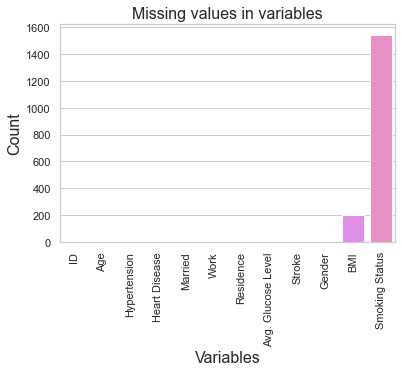

In [68]:
# Visualize the number of missing values(explicit) in each columns
# We replace the misleading values to be np.nan so that we can visualize it in the bar of missing values
# In addition replacing them with np.nan prevents our visualizations from misleading the readers as 
# they would no longer have misleading labels 
# These will later be replaced with mean, median or mode depending on the type and distribution of each variable
data.loc[data['gender'] == 'Other', 'gender'] = np.nan
data.loc[data['smoking_status'] == 'Unknown', 'smoking_status'] = np.nan
labels = ['ID', 'Age', 'Hypertension', 'Heart Disease', 'Married', 'Work', 'Residence', 'Avg. Glucose Level', 'Stroke','Gender', 'BMI', 'Smoking Status']
plot_missing_bar(labels)

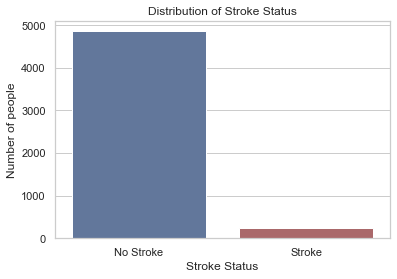

<Figure size 432x288 with 0 Axes>

In [69]:
# Plot the distribution of the outcome variable
variable_name = 'stroke'
label = "Stroke Status"
rotate_label = False
x_label = ["No Stroke", "Stroke"]
plot_chart(variable_name, label, rotate_label, x_label)

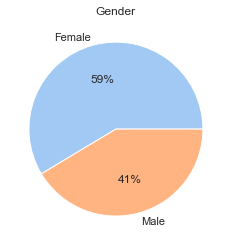

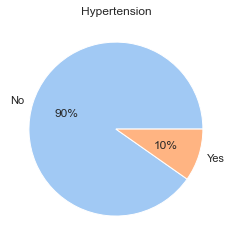

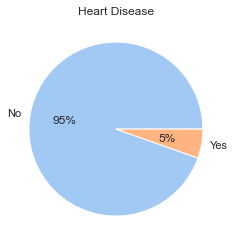

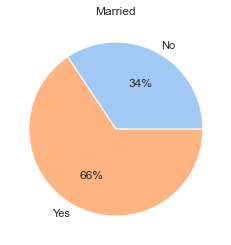

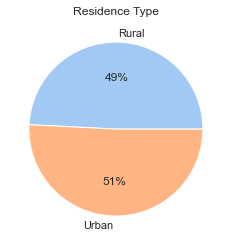

<Figure size 432x288 with 0 Axes>

In [70]:
# Plot pie charts of binary categories
list_variables = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
title = ["Gender", "Hypertension", "Heart Disease", "Married", "Residence Type"]
labels = [None, ['No', 'Yes'], ['No', 'Yes'], None, None]
cnt = 0
for variable_name in list_variables:
    plot_pie(variable_name, title[cnt], labels[cnt])
    cnt = cnt + 1

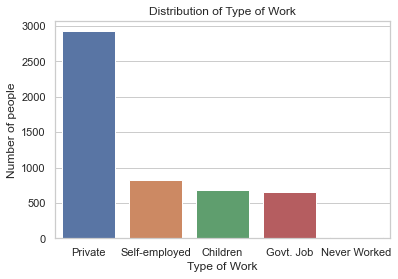

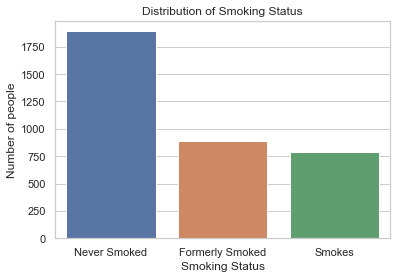

<Figure size 432x288 with 0 Axes>

In [71]:
# Plot bar chart of multiple categories
list_variables = ['work_type', 'smoking_status']
label = ["Type of Work", "Smoking Status"]
x_labels = [['Private', 'Self-employed', 'Children', 'Govt. Job', 'Never Worked'], [ 'Never Smoked', 'Formerly Smoked', 'Smokes']]
rotate_label = [False, False]
cnt = 0
for variable_name in list_variables:
    plot_chart(variable_name, label[cnt], rotate_label[cnt], x_labels[cnt])
    cnt = cnt + 1

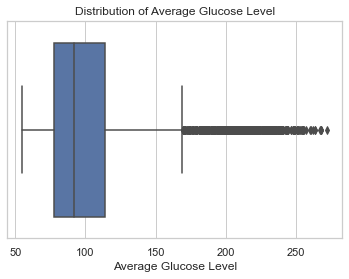

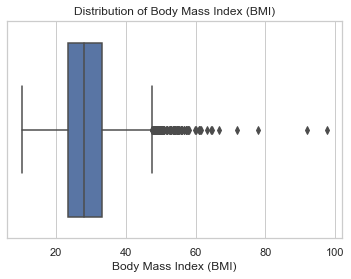

<Figure size 432x288 with 0 Axes>

In [72]:
# Plot box whisker plot of numerical values
list_variables = ['avg_glucose_level', 'bmi']
label = ['Average Glucose Level', 'Body Mass Index (BMI)']
cnt = 0
for variable_name in list_variables:
    plot_boxplot(variable_name, label[cnt])
    cnt = cnt + 1

In [73]:
# Remove the outliers in numerical values
list_variables = ['avg_glucose_level', 'bmi']
for variable in list_variables:
    q_low = data[variable].quantile(0.01)
    q_hi  = data[variable].quantile(0.99)
    data = data[(data[variable] < q_hi) & (data[variable] > q_low)]

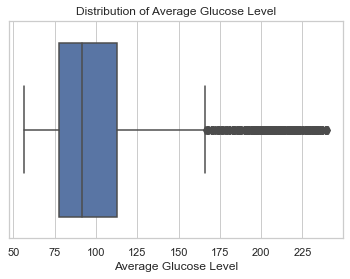

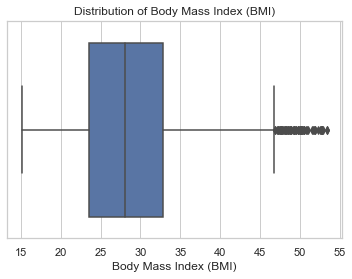

<Figure size 432x288 with 0 Axes>

In [74]:
# PLot box plot of numerical values and ensure the outliers are removed
list_variables = ['avg_glucose_level', 'bmi']
label = ['Average Glucose Level', 'Body Mass Index (BMI)']
cnt = 0
for variable_name in list_variables:
    plot_boxplot(variable_name, label[cnt])
    cnt = cnt + 1

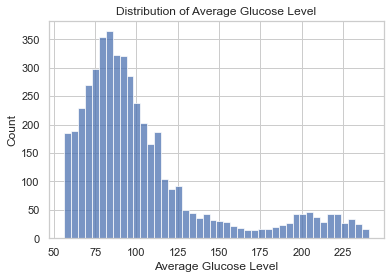

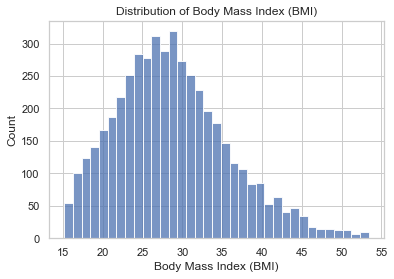

<Figure size 432x288 with 0 Axes>

In [75]:
# Plot histograms of numerical values
list_variables = ['avg_glucose_level', 'bmi']
label = ['Average Glucose Level', 'Body Mass Index (BMI)']
cnt = 0
for variable_name in list_variables:
    plot_histogram(variable_name, label[cnt])
    cnt = cnt + 1

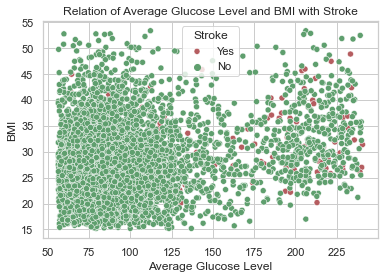

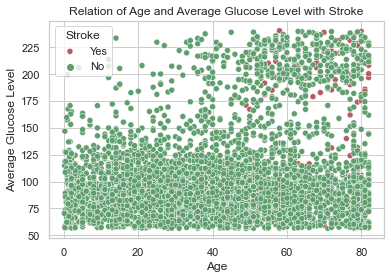

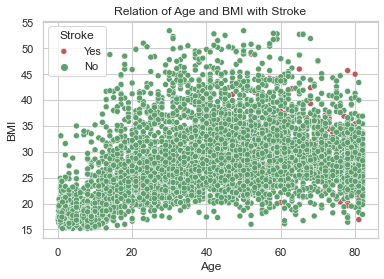

<Figure size 432x288 with 0 Axes>

In [76]:
# Plot scatter plot of numerical values with hue of stroke
list_variables = [("avg_glucose_level", "bmi"), ("age", "avg_glucose_level"), ("age", "bmi")]
labels = [("Average Glucose Level", "BMI"), ("Age","Average Glucose Level"), ("Age", "BMI") ]
count = 0
for variables in list_variables:
    plot_scatter(variables[0], variables[1], labels[count][0], labels[count][1])
    count = count + 1

In [77]:
# Replace the average glucose level with its logarithm as it is right skewed
data['avg_glucose_level'] = np.log(data['avg_glucose_level'])

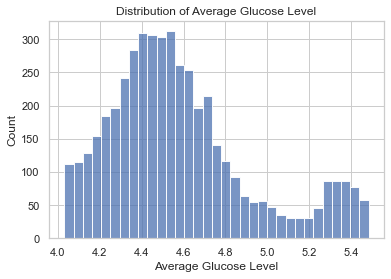

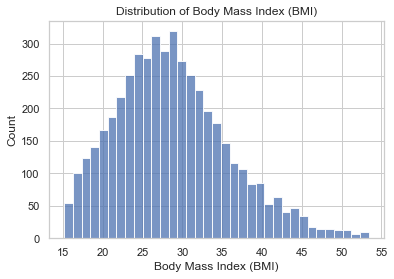

<Figure size 432x288 with 0 Axes>

In [78]:
# Ensure that numerical values are no longer skewed as before
list_variables = ['avg_glucose_level', 'bmi']
label = ['Average Glucose Level', 'Body Mass Index (BMI)']
cnt = 0
for variable_name in list_variables:
    plot_histogram(variable_name, label[cnt])
    cnt = cnt + 1

In [79]:
# Replace missing BMI values with the median
data['bmi'].fillna(data['bmi'].median(), inplace=True)

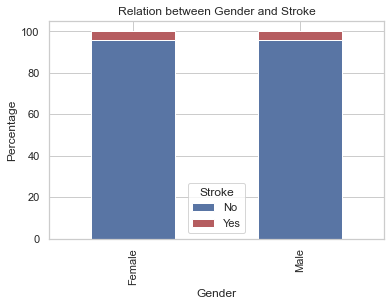

<Figure size 432x288 with 0 Axes>

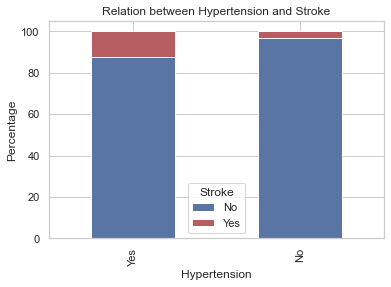

<Figure size 432x288 with 0 Axes>

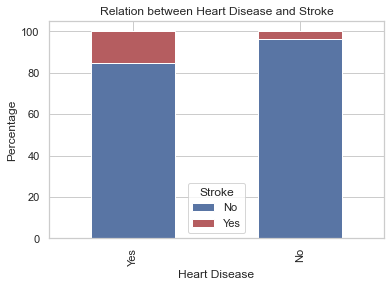

<Figure size 432x288 with 0 Axes>

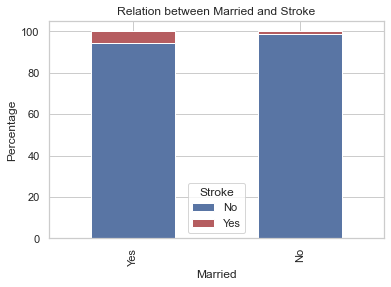

<Figure size 432x288 with 0 Axes>

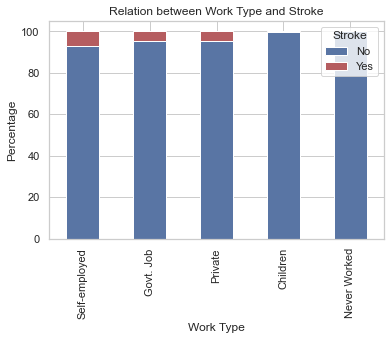

<Figure size 432x288 with 0 Axes>

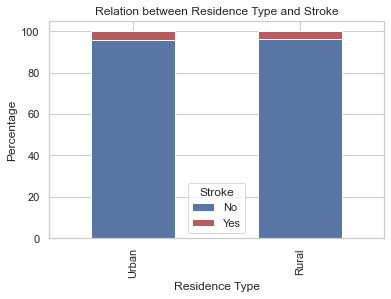

<Figure size 432x288 with 0 Axes>

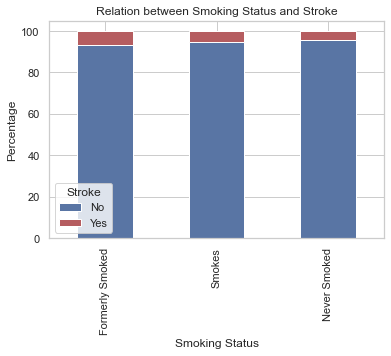

<Figure size 432x288 with 0 Axes>

In [80]:
# Plot the relation of different categorical variables and stroke in bar chart
list_variables = data.columns.drop(['id', 'age', 'avg_glucose_level', 'bmi', 'stroke'])
label = ['Gender', "Hypertension", "Heart Disease", "Married", "Work Type", "Residence Type", "Smoking Status"]
x_labels = [None, ['Yes', 'No'], ['Yes', 'No'], None, ['Self-employed', 'Govt. Job', 'Private', 'Children', 'Never Worked'], None, [ 'Formerly Smoked', 'Smokes', 'Never Smoked']]
cnt = 0
for variable_name in list_variables:
    plot_relation_chart(variable_name, label[cnt], x_labels[cnt])
    cnt = cnt + 1

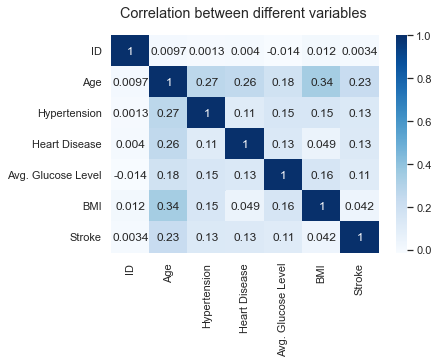

In [81]:
plot_correlationmatrix()

In [82]:
# Replace the missing value in gender with the mode
data['gender'].fillna(data['gender'].mode()[0], inplace=True)

# Replace the missing value in smoking status with the mode of gender's smoking status
mode = {}
mode["Male"] = data[data.gender == "Male"].smoking_status.mode()[0]
mode["Female"] = data[data.gender == "Female"].smoking_status.mode()[0]
data.smoking_status[data.gender == "Male"].fillna(mode["Male"], inplace=True)
data.smoking_status[data.gender == "Female"].fillna(mode["Female"], inplace=True)

In [83]:
# Standardise the numerical values
data.loc[:, data.columns == 'bmi'] = preprocessing.scale(data.loc[:, data.columns  == 'bmi'], axis=0)
data.loc[:, data.columns == 'avg_glucose_level'] = preprocessing.scale(data.loc[:, data.columns  == 'avg_glucose_level'], axis=0)

In [84]:
# Check if they have been standardised
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4707.000000,4707.000000,4707.000000,4707.000000,4.707000e+03,4.707000e+03,4707.000000
mean,36920.263437,43.048345,0.089229,0.049501,-4.775704e-16,-1.595636e-16,0.042065
std,20944.708885,22.350624,0.285104,0.216934,1.000106e+00,1.000106e+00,0.200759
min,77.000000,0.080000,0.000000,0.000000,-1.608167e+00,-1.909247e+00,0.000000
25%,18421.000000,25.000000,0.000000,0.000000,-6.811475e-01,-7.252973e-01,0.000000
50%,37320.000000,44.000000,0.000000,0.000000,-1.866216e-01,-9.103871e-02,0.000000
75%,54821.500000,60.000000,0.000000,0.000000,4.220070e-01,5.855038e-01,0.000000
max,72940.000000,82.000000,1.000000,1.000000,2.630167e+00,3.474904e+00,1.000000


### Data Modeling

In [85]:
# Get X and y values and create dummies of categorical variables
X, y = data.drop(['id', 'stroke'], axis = 1), data['stroke']
X = pd.get_dummies(X, drop_first=True)

In [86]:
# Split the data into train and test set with split ratio of 80:20
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [87]:
# Oversample the training data
# Dont oversample the test data as test data have to represent the real world distribution of outcome variable
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train,y_train.ravel())

In [88]:
# Different models to train and test
models = []
models.append(['Logistic Regression', LogisticRegression(solver ='lbfgs', random_state=42, max_iter=1000)])
models.append(['Support Vector Machine', SVC(probability = True, gamma = 'scale', random_state=42)])
models.append(['KNeigbors', KNeighborsClassifier()])
models.append(['SGD Classifier', SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)])
models.append(['DecisionTree', DecisionTreeClassifier(random_state=42)])
models.append(['Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)])
models.append(["Hard Voting", VotingClassifier(estimators=[(models[0][0], models[0][1]), (models[1][0], models[1][1]), (models[2][0], models[2][1]), (models[3][0], models[3][1]), (models[4][0], models[4][1]), (models[5][0], models[5][1])], voting='hard')])
models.append(["Hard Voting (Selective)", VotingClassifier(estimators=[(models[3][0], models[3][1]), (models[1][0], models[1][1]), (models[2][0], models[2][1])], voting='hard')])
models.append(["Soft Voting", VotingClassifier(estimators=[(models[0][0], models[0][1]), (models[1][0], models[1][1]), (models[2][0], models[2][1]), (models[3][0], CalibratedClassifierCV(models[3][1])), (models[4][0], models[4][1]), (models[5][0], models[5][1])], voting='soft')])
models.append(["Soft Voting (Selective)", VotingClassifier(estimators=[(models[3][0], CalibratedClassifierCV(models[3][1])), (models[1][0], models[1][1]), (models[2][0], models[2][1])], voting='soft')])

Training and testing Logistic Regression
ROC AUC Score: 0.62 %

Recall: 0.41 %

Precision: 0.11 %

F1 Score: 0.17 %

Accuracy Score:  0.8110403397027601

K-Fold Validation Mean Accuracy: 84.24 %



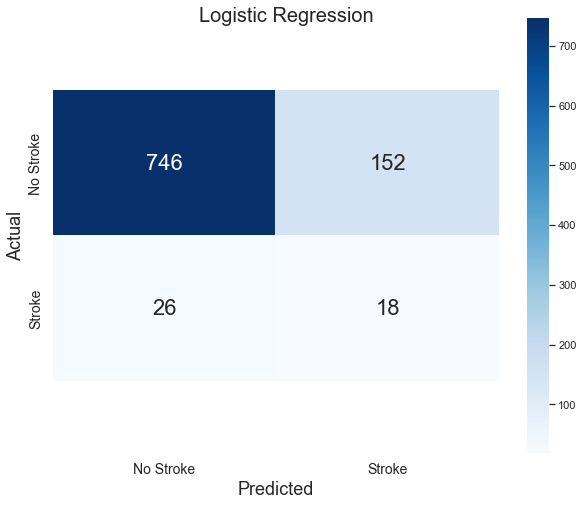

----------------------------------------




Training and testing Support Vector Machine
ROC AUC Score: 0.74 %

Recall: 0.80 %

Precision: 0.11 %

F1 Score: 0.19 %

Accuracy Score:  0.6900212314225053

K-Fold Validation Mean Accuracy: 78.08 %



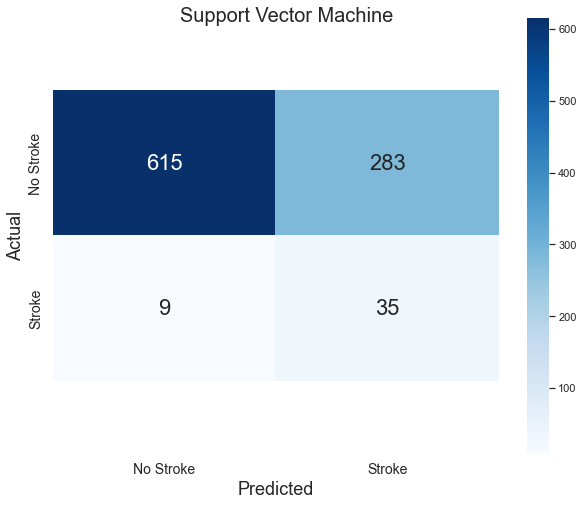

----------------------------------------




Training and testing KNeigbors
ROC AUC Score: 0.64 %

Recall: 0.45 %

Precision: 0.12 %

F1 Score: 0.19 %

Accuracy Score:  0.8174097664543525

K-Fold Validation Mean Accuracy: 91.07 %



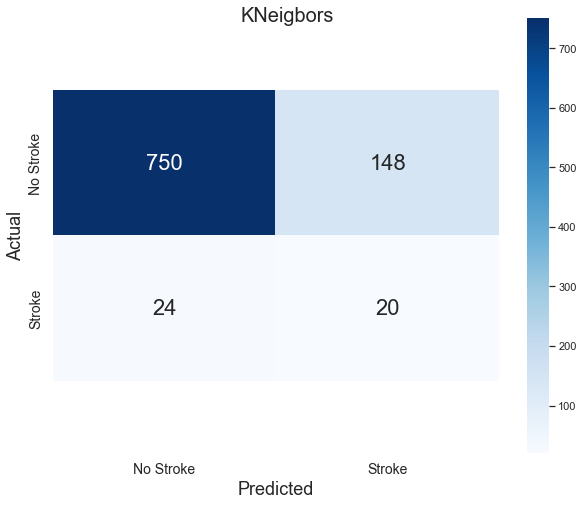

----------------------------------------




Training and testing SGD Classifier
ROC AUC Score: 0.66 %

Recall: 0.48 %

Precision: 0.13 %

F1 Score: 0.21 %

Accuracy Score:  0.8290870488322718

K-Fold Validation Mean Accuracy: 79.55 %



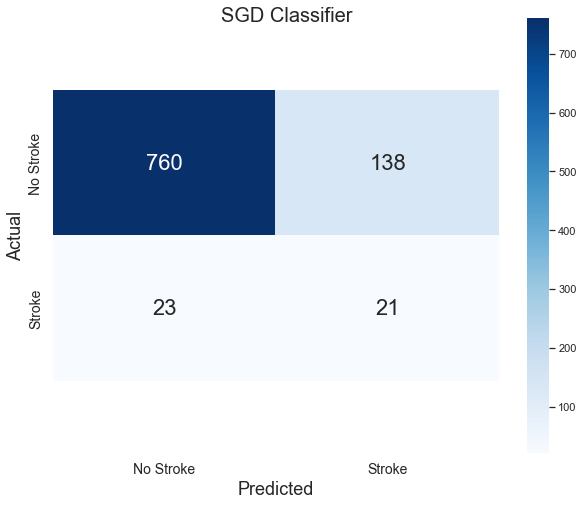

----------------------------------------




Training and testing DecisionTree
ROC AUC Score: 0.54 %

Recall: 0.16 %

Precision: 0.09 %

F1 Score: 0.12 %

Accuracy Score:  0.8885350318471338

K-Fold Validation Mean Accuracy: 93.66 %



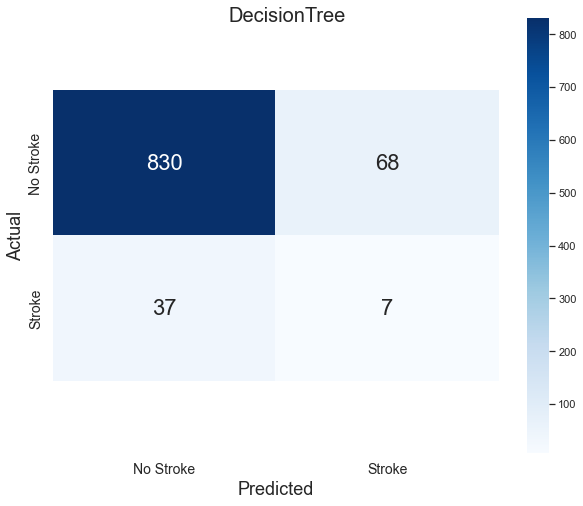

----------------------------------------




Training and testing Random Forest
ROC AUC Score: 0.56 %

Recall: 0.18 %

Precision: 0.13 %

F1 Score: 0.15 %

Accuracy Score:  0.9065817409766455

K-Fold Validation Mean Accuracy: 95.36 %



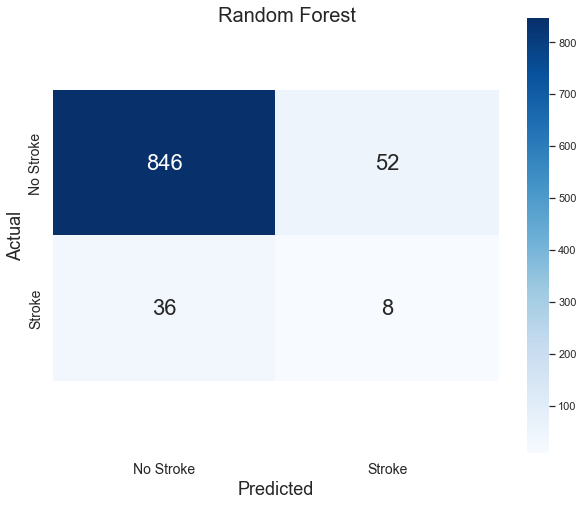

----------------------------------------




Training and testing Hard Voting
ROC AUC Score: 0.60 %

Recall: 0.30 %

Precision: 0.12 %

F1 Score: 0.17 %

Accuracy Score:  0.8683651804670913

K-Fold Validation Mean Accuracy: 90.54 %



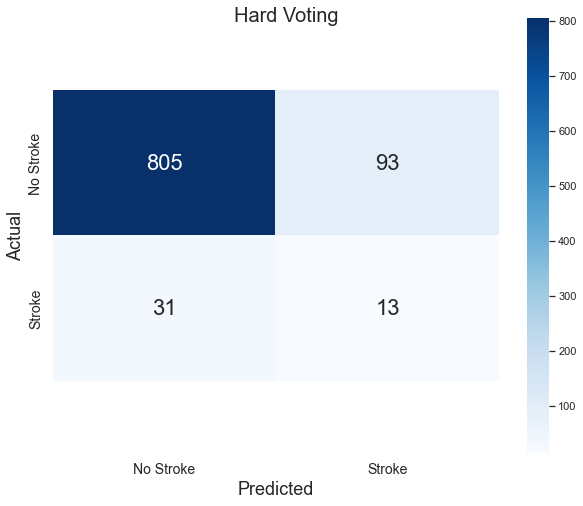

----------------------------------------




Training and testing Hard Voting (Selective)
ROC AUC Score: 0.72 %

Recall: 0.64 %

Precision: 0.13 %

F1 Score: 0.22 %

Accuracy Score:  0.7919320594479831

K-Fold Validation Mean Accuracy: 82.75 %



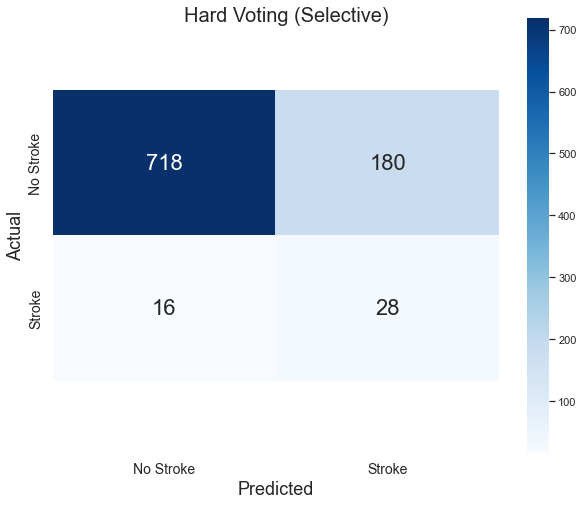

----------------------------------------




Training and testing Soft Voting
ROC AUC Score: 0.64 %

Recall: 0.41 %

Precision: 0.14 %

F1 Score: 0.21 %

Accuracy Score:  0.8577494692144374

K-Fold Validation Mean Accuracy: 92.58 %



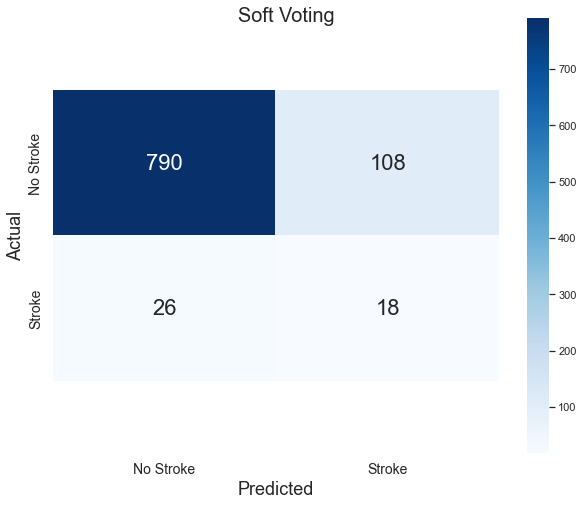

----------------------------------------




Training and testing Soft Voting (Selective)
ROC AUC Score: 0.71 %

Recall: 0.61 %

Precision: 0.14 %

F1 Score: 0.22 %

Accuracy Score:  0.8004246284501062

K-Fold Validation Mean Accuracy: 86.62 %



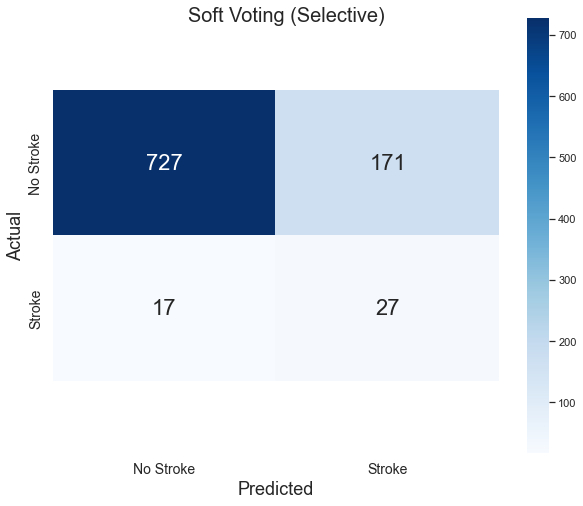

----------------------------------------






In [89]:
lst_1 = []
for m in range(len(models)):
    lst_2 = []
    model = models[m][1]
    model.fit(X_train_res,y_train_res)
    y_pred = model.predict(X_test)
    cm =confusion_matrix(y_test,y_pred)
    accuracies = cross_val_score(estimator= model, X = X_train_res,y = y_train_res, cv=10)
    roc = roc_auc_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    print("Training and testing", models[m][0])
    print('ROC AUC Score: {:.2f} %'.format(roc))
    print('')
    print('Recall: {:.2f} %'.format(recall))
    print('')
    print('Precision: {:.2f} %'.format(precision))
    print('')
    print('F1 Score: {:.2f} %'.format(f1))
    print('')
    print('Accuracy Score: ',accuracy_score(y_test,y_pred))
    print('')
    print('K-Fold Validation Mean Accuracy: {:.2f} %'.format(accuracies.mean()*100))
    print('')
    plot_confusionmatrix(y_test, y_pred, cm, models[m][0])
    lst_2.append(models[m][0])
    lst_2.append(roc)
    lst_2.append(recall)
    lst_2.append(precision)
    lst_2.append(f1)
    lst_2.append(accuracy_score(y_test,y_pred)*100)
    lst_2.append(accuracies.mean()*100)
    lst_1.append(lst_2)
    print('-'*40)
    print('')
    print('')
    print('')
    print('')

In [90]:
# Calculating the top 3 feature(permutation) importance for the selected models (SVM, KNN, and SGD)
features = ['Age', 'Hypertension', 'Heart Disease', 'Avg. Glucose Level', 'BMI', 'Gender', 'Married', 'Work (Never worked)', 'Work (Private)', 'Work (Self employed)', 'Work (Children)', 'Residence', 'Smoking status (Never smoked)', 'Smoking status (Smokes)']
df_featimp = pd.DataFrame()
for m in range(1, 4):
    model = models[m][1]
    model.fit(X_train_res,y_train_res)
    results = permutation_importance(model, X_test, y_test, scoring='recall', random_state=10)
    importance = results.importances_mean
    temp_dict = {'Model':models[m][0], 'Feature':features, 'Importance':importance}
    temp_df = pd.DataFrame(temp_dict).sort_values('Importance', ascending=False)
    df_featimp = df_featimp.append(temp_df[0:3], ignore_index=True)
df_featimp

,Model,Feature,Importance
0,Support Vector Machine,Age,0.477273
1,Support Vector Machine,Work (Private),0.027273
2,Support Vector Machine,Avg. Glucose Level,0.022727
3,KNeigbors,Age,0.318182
4,KNeigbors,Avg. Glucose Level,0.104545
5,KNeigbors,BMI,0.045455
6,SGD Classifier,Age,0.331818
7,SGD Classifier,Married,0.018182
8,SGD Classifier,Heart Disease,0.004545


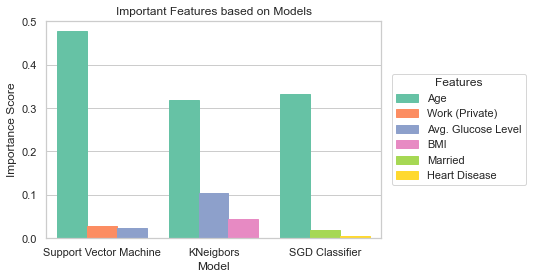

In [91]:
plot_importance(df_featimp)

In [92]:
df_result = pd.DataFrame(lst_1, columns=['Model','ROC AUC','Recall','Precision','F1 Score', 'Accuracy','K-Fold Mean Accuracy'])
df_result.sort_values(by=['Recall', 'ROC AUC'],inplace=True,ascending=False)
df_result

,Model,ROC AUC,Recall,Precision,F1 Score,Accuracy,K-Fold Mean Accuracy
1,Support Vector Machine,0.740155,0.795455,0.110063,0.193370,69.002123,78.080597
7,Hard Voting (Selective),0.717959,0.636364,0.134615,0.222222,79.193206,82.746980
9,Soft Voting (Selective),0.711607,0.613636,0.136364,0.223140,80.042463,86.623870
3,SGD Classifier,0.661799,0.477273,0.132075,0.206897,82.908705,79.548339
2,KNeigbors,0.644867,0.454545,0.119048,0.188679,81.740977,91.068934
8,Soft Voting,0.644412,0.409091,0.142857,0.211765,85.774947,92.578534
0,Logistic Regression,0.619913,0.409091,0.105882,0.168224,81.104034,84.242767
6,Hard Voting,0.595946,0.295455,0.122642,0.173333,86.836518,90.543001
5,Random Forest,0.561956,0.181818,0.133333,0.153846,90.658174,95.362199
4,DecisionTree,0.541684,0.159091,0.093333,0.117647,88.853503,93.658713


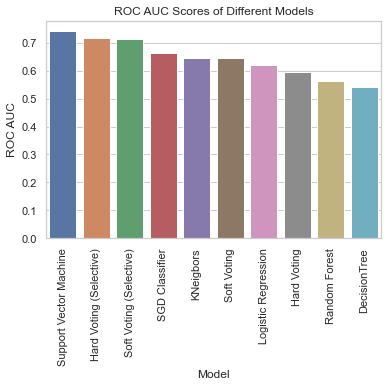

In [93]:
plot_result('ROC AUC', df_result)

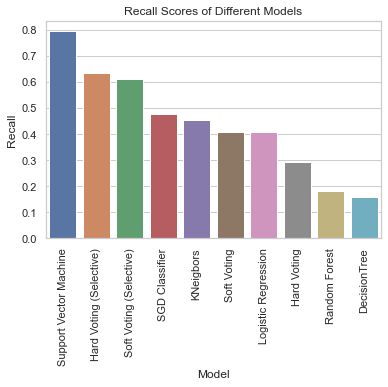

In [94]:
plot_result('Recall', df_result)